# rMATS integration

Done:
* make rmats table in a similar format to isotools differential event result tables
* compute overlaps with differential events
* make PCA plots of rMATS PSI values
    * 3AS correlates good with SF3B1
* recompute rMATS p-values with isotools statistical approach
    * poor correlation- potentially issue with PSI values/JC vs exon counts
  
Todo:
* "Ideal" mode: Isotools transcripts with GENCODE combined?
    * gtf+ events
* how to copute PSI values? exon count vs junction counts?
    * affects PCA and statistical test. 
    * look at correlation with provided PSI values - 
        * is JC only closer to provided PSI?
        * how are provided PSI computed - can it be reproduced?
        * if not - which events are different (and why)?        
* PCA correlates with study
    * run for large studies individually
* Model for mutation effect
    * first define subset of commonly affected 3'as events


In [1]:
import logging
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pathlib
from  isotools import Transcriptome
import isotools
logger=logging.getLogger('isotools')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger.info(f'This is isotools version {isotools.__version__}')


INFO:This is isotools version 0.3.2


In [2]:
path='/project/42/pacbio/golong'
date='2022_12'
project='golong_all'
out_path=f'{path}/06-isotools/{project}/results_{date}'
table_path=f'{out_path}/04_differential_splicing/tables_rmats'
plot_path=f'{out_path}/04_differential_splicing/plots_rmats'
pathlib.Path(plot_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(table_path).mkdir(parents=True, exist_ok=True)

ref_fn=f'{path}/../references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'

In [3]:
# set plot parameters
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["font.size"]=8
plt.rcParams["font.family"]='sans-serif'#"Times New Roman"
plt.rcParams['figure.dpi']=200


In [4]:
samples=pd.read_csv(f'{out_path}/01_transcriptome/{project}_{date}_samples.csv').set_index('name')

illu_ids=[(k,glob(f'{path}/07-star/gencode_36/*{v}*sortedByCoord.out.bam')) for k,v in samples['illumina_sample_id'].items() if v==v]
illu_ids={v[0]:k for k,v in illu_ids if v}   

In [5]:
# define group and sample colors

groups={grpn:samples.index[samples.group==grpn].tolist() for grpn in set(samples.group)}
group_dict={sa:gn for gn,sa_list in groups.items() for sa in sa_list}
group_num={sa:i for i,sa in enumerate(['K562_mut','K562_wt','Nalm6_mut', 'Nalm6_wt','CLL_mut','CLL_wt', 'MDS_mut', 'MDS_wt','B-cell'])}

groups['CL_wt']=[sa for gr in ['K562_wt', 'Nalm6_wt'] for sa in groups[gr]]
groups['CL_mut']=[sa for gr in ['K562_mut', 'Nalm6_mut'] for sa in groups[gr]]
#groups['GM12878_ENCODE']=isoseq.groups()['GM12878']
group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']

sample_colors={sa:group_colors[k] for sa in samples.index.tolist() for k in group_colors if sa in groups.get(k,[]) }
sample_colors={sa:sample_colors.get(sa,'#003C30') for sa in samples.index.tolist()}
sample_colors['reference']=group_colors['other']

groups_CL={k:v for k,v in groups.items() if k[:3] in ['CL_', 'GM1']}
groups_CLL={k:v for k,v in groups.items() if k in ['CLL_wt', 'CLL_mut', 'B-cell']}
groups_MDS={k:v for k,v in groups.items() if k in ['MDS_wt', 'MDS_mut', 'B-cell']}

group_same_colors={k:group_colors["all_"+k.split("_")[1]] for k in group_colors if 'wt' in k or 'mut' in k}
group_same_colors['B-cell']=group_colors['B-cell']


## Prepare the rMATS result tables

In [6]:
#step 1: read the rmats result table
import statsmodels.stats.multitest as multi

rmats_groups={'SF3B1':{'CL':{}, 'CLL':{}, 'MDS':{}}}
type_dict={'ES':'SE', 'IR':'RI', 'ME':'MXE', '3AS':'A3SS', '5AS':'A5SS'}
type_dict2={v:k for k,v in type_dict.items()}
cols={'ME':['upstreamEE','downstreamES'],  
      'IR':['upstreamEE','downstreamES'], 
      'ES':['upstreamEE','downstreamES'],
      '3AS+':['flankingEE','shortES'],
      '3AS-':['shortEE','flankingES'],
      '5AS+':['shortEE','flankingES'],
      '5AS-':['flankingEE','shortES']}


colnames=['gene','gene_id','chrom','strand', 'start', 'end']

for grpn in rmats_groups['SF3B1']:
    rmats_path=f'{path}/08-rMATS/gencode_36/{grpn}' if grpn!='MDS' else f'{path}/additional_samples/MDS/rmats/gencode_36'

    with open(f'{rmats_path}/b1.txt', "r") as b1:
        b1=[illu_ids.get(file,os.path.basename(file).split('Aligned')[0]) for file in b1.read().rstrip().split(',')]
    with open(f'{rmats_path}/b2.txt', "r") as b2:
        b2=[illu_ids.get(file,os.path.basename(file).split('Aligned')[0]) for file in b2.read().rstrip().split(',')]
    rmats_groups['SF3B1'][grpn]={f'{grpn}_{gt}':sa for gt,sa in (('mut',b1), ('wt',b2))}
        

for mode in ['gencode', 'isotools', 'rmats','isotools_novel', 'rmats_novel']:
    print(mode)    
    rmats_path={'gencode':'gencode_36', 'isotools':'gencode_36_golong_all', 'rmats':'gencode_36_rMATS', 'isotools_novel':'isotools_golong_all', 'rmats_novel':'gencode_36_rMATS_novel'}
    rmats_path={grpn:f'{path}/08-rMATS/{rmats_path[mode]}/{grpn}' if grpn!='MDS' else f'{path}/additional_samples/MDS/rmats/{rmats_path[mode]}'  for grpn in ('CL','CLL','MDS')}
    for grpn in ('CL','CLL','MDS'):
        #check if file exists
        table_file_path = f'{table_path}/rmats_results_{grpn}_{mode}.csv'
        if os.path.exists(table_file_path):
            print(f"File {table_file_path} exists already")
            continue
        rmats_event={}
        try:
            with open(f'{rmats_path[grpn]}/b1.txt', "r") as b1:
                b1=[illu_ids.get(file,os.path.basename(file).split('Aligned')[0]) for file in b1.read().rstrip().split(',')]
            with open(f'{rmats_path[grpn]}/b2.txt', "r") as b2:
                b2=[illu_ids.get(file,os.path.basename(file).split('Aligned')[0]) for file in b2.read().rstrip().split(',')]
        
            for effect in ['A3SS', 'A5SS', 'MXE', 'RI', 'SE']:
                tab=pd.read_csv(f'{rmats_path[grpn]}/{effect}.MATS.JCEC.txt', sep='\t')
                print(f'{grpn} {effect} has {sum((tab.FDR<.1)&(abs(tab.IncLevelDifference)>.1))}/{len(tab)} differential events')
                effect2=type_dict2[effect]
                if effect2 in cols:                
                    event_cols=['geneSymbol','GeneID','chr','strand']+cols[effect2]                
                    rmats_event[effect]=tab[event_cols]
                    rmats_event[effect].columns=colnames
                else:
                    event_cols_p=['geneSymbol','GeneID','chr','strand']+cols[effect2+'+']     
                    event_cols_m=['geneSymbol','GeneID','chr','strand']+cols[effect2+'-']
                    eventtab_p=tab.loc[tab.strand=='+',event_cols_p]
                    eventtab_m=tab.loc[tab.strand=='-',event_cols_m]
                    eventtab_p.columns=colnames
                    eventtab_m.columns=colnames
                    rmats_event[effect]=pd.concat([eventtab_p, eventtab_m]).sort_index()
                rmats_event[effect]=rmats_event[effect].assign(splice_type=effect2)
                rmats_psi=pd.concat([tab[col].str.split(',', expand=True).replace('NA','NaN').astype(float) for col in ['IncLevel1', 'IncLevel2']], axis=1)
                rmats_psi.columns=b1+b2
                rmats_k=pd.concat([tab[col].str.split(',', expand=True).replace('NA','NaN').astype(float) for col in ['IJC_SAMPLE_1', 'IJC_SAMPLE_2']], axis=1)
                rmats_k.columns=[f'{sa}_{grpn}_{gt}_in_cov' for saL, gt in ((b1,'mut'),(b2,'wt')) for sa in saL]
                rmats_n=pd.concat([tab[col].str.split(',', expand=True).replace('NA','NaN').astype(float) for col in ['SJC_SAMPLE_1', 'SJC_SAMPLE_2']], axis=1)
                rmats_n.columns=[f'{sa}_{grpn}_{gt}_total_cov' for saL, gt in ((b1,'mut'),(b2,'wt')) for sa in saL]
                rmats_n+=rmats_k.values
                rmats_counts=pd.concat([rmats_k,rmats_n], axis=1)
                rmats_counts=rmats_counts[[col for csa in zip(rmats_k.columns,rmats_n.columns) for col in csa]]
                rmats_stats=pd.concat([tab['PValue'],tab['FDR']]+[tab[col].str.split(',', expand=True).replace('NA','NaN').astype(float).mean(1) for col in ['IncLevel1', 'IncLevel2']], axis=1)
                rmats_stats.columns=['pvalue', 'padj_rmats']+[f'{grpn}_{gt}_PSI' for gt in ('mut','wt')]
                rmats_event[effect]=pd.concat([rmats_event[effect], rmats_stats,rmats_counts ], axis=1)
        except FileNotFoundError:
            print(f'skipping {grpn} {mode} ({rmats_path[grpn]})')
            continue
        rmats_results=pd.concat(rmats_event.values())
        mask = np.isfinite(rmats_results['pvalue'])
        padj = np.empty(mask.shape)
        padj.fill(np.nan)
        padj[mask] = multi.multipletests(rmats_results.loc[mask, 'pvalue'], method='fdr_bh')[1]
        rmats_results.insert(7, 'padj', padj)
        rmats_results=rmats_results.sort_values('pvalue')
        rmats_results.to_csv( f'{table_path}/rmats_results_{grpn}_{mode}.csv')
        rmats_results.loc[rmats_results.padj<.1].to_csv( f'{table_path}/rmats_results_{grpn}_{mode}_sig.csv')
        
    


gencode
File /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/04_differential_splicing/tables_rmats/rmats_results_CL_gencode.csv exists already
File /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/04_differential_splicing/tables_rmats/rmats_results_CLL_gencode.csv exists already
File /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/04_differential_splicing/tables_rmats/rmats_results_MDS_gencode.csv exists already
isotools
File /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/04_differential_splicing/tables_rmats/rmats_results_CL_isotools.csv exists already
File /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/04_differential_splicing/tables_rmats/rmats_results_CLL_isotools.csv exists already
File /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/04_differential_splicing/tables_rmats/rmats_results_MDS_isotools.csv exists already
rmats
File /project/42/pacbio/golong/06-isotools/golong_all/resu

In [7]:
# recompute p-values
min_alt_fraction=.05
from isotools._transcriptome_stats import betabinom_lr_test as test
from tqdm import tqdm
import statsmodels.stats.multitest as multi
from tqdm import tqdm
for mode in ['isotools_novel','gencode', 'isotools', 'rmats', 'rmats_novel']:

    print(mode)    
    for grpn in ('MDS','CL','CLL'):
        #check if file exists
        if os.path.exists(f'{table_path}/rmats_results_{grpn}_{mode}_reeval.csv'):
            print(f"File rmats_results_{grpn}_{mode}_reeval.csv exists already")
            continue
        table_file_path = f'{table_path}/rmats_results_{grpn}_{mode}.csv'
        try:
            res_rmats=pd.read_csv(table_file_path)
        except FileNotFoundError:
            continue
        
        rmats_groups=[c.replace('_total_cov','').rsplit('_',2) for c in res_rmats.columns if 'total_cov' in c]
        rmats_groups={f'{grpn}_{gt}':[sa[0].strip('_') for sa in rmats_groups if sa[1]==grpn and sa[2] ==gt] for gt in ('wt','mut')}
        k = res_rmats[[c for c in res_rmats.columns if c.endswith('_in_cov') ]]
        n = res_rmats[[c for c in res_rmats.columns if c.endswith('_total_cov') ]]
        n.columns = [c.rsplit('_',5)[0] for c in n.columns]
        k.columns = [c.rsplit('_',5)[0] for c in k.columns]
        nsum = n.sum(1)
        ksum = k.sum(1)
        covered = (nsum >= min_total) & (min_alt_fraction < ksum / nsum) & (ksum / nsum < 1 - min_alt_fraction)
        covered=covered.index[covered]
        pvals=[]
        params=[]
        for idx in tqdm(covered):
            k_i=[k.loc[idx,grp] for grp in rmats_groups.values()]
            n_i=[n.loc[idx,grp] for grp in rmats_groups.values()]
            pval_i, params_i = test(k_i[:2], n_i[:2])
            pvals.append(pval_i)
            params.append(params_i)
            
        params=pd.DataFrame(params, columns=[f'{grname}_{what}' for grname in list(rmats_groups)+['total']  for what in ('PSI', 'disp')], index=covered)
        res_rmats['nbinom_pval']=np.nan
        res_rmats.loc[covered, 'nbinom_pval']=pvals
        res_rmats=pd.concat([res_rmats, params], axis=1)
        res_rmats.to_csv( f'{table_path}/rmats_results_{grpn}_{mode}_reeval.csv')

isotools_novel
File rmats_results_MDS_isotools_novel_reeval.csv exists already
gencode
File rmats_results_MDS_gencode_reeval.csv exists already
File rmats_results_CL_gencode_reeval.csv exists already
File rmats_results_CLL_gencode_reeval.csv exists already
isotools
File rmats_results_MDS_isotools_reeval.csv exists already
File rmats_results_CL_isotools_reeval.csv exists already
File rmats_results_CLL_isotools_reeval.csv exists already
rmats
File rmats_results_MDS_rmats_reeval.csv exists already
File rmats_results_CL_rmats_reeval.csv exists already
File rmats_results_CLL_rmats_reeval.csv exists already
rmats_novel


In [8]:
mode='isotools_novel'
grpn='MDS'
res_rmats=pd.read_csv(f'{table_path}/rmats_results_{grpn}_{mode}_reeval.csv')

Text(0, 0.5, 'log10 nbinom pval')

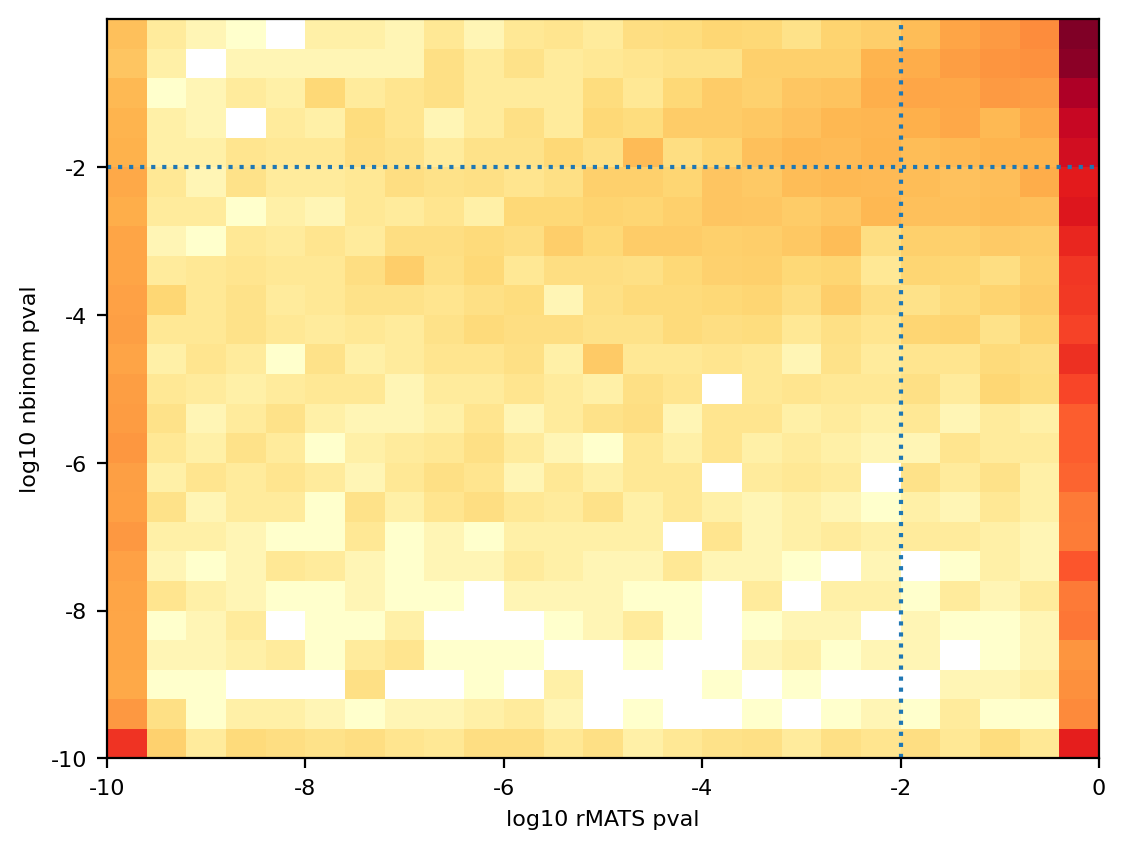

In [20]:
from matplotlib.colors import LogNorm
res_rmats.columns.tolist()[-20:]
#pvalue
sel=(res_rmats.pvalue==res_rmats.pvalue) & (res_rmats.nbinom_pval==res_rmats.nbinom_pval)
#plt.rcParams["figure.figsize"] = (10,5)
fig, ax=plt.subplots()
hist=ax.hist2d(np.log10(res_rmats.loc[sel,'pvalue']+1e-10),np.log10(res_rmats.loc[sel,'nbinom_pval']+1e-10), 25,norm=LogNorm(),cmap='YlOrRd')
ax.axhline(np.log10(.01), ls=":")
ax.axvline(np.log10(.01), ls=":")
ax.set_xlabel('log10 rMATS pval')
ax.set_ylabel('log10 nbinom pval')
# not a good correlation... maybe due to exon reads vs sj reads...

## Compare to IsoTools

* intersections of events
    * all events
    * known / novel events
    * by splice type
    * significant in isotools/rmats/both
* depict as venn diagrams

In [21]:
mode='isotools_novel'
version='less_strict'
min_total=50
min_alt_fraction=.05
event_intersect={}
for mode in ['gencode', 'isotools', 'rmats','isotools_novel']:#, 'rmats_novel']:
    event_intersect[mode]={}
    results=pd.read_csv(f'{out_path}/04_differential_splicing/tables/{project}_{date}_diff_betabinomial_{version}_all.csv').set_index(['chrom','strand','start','end','splice_type']).sort_index() 
    results=results[~results.index.duplicated(keep='first')]
    sig_isotools=results.padj<.1
    known=~results.novel

    for grpn in ('CL', 'CLL', 'MDS'):
        try:
            #results=pd.read_csv(f'{out_path}/04_differential_splicing/tables/{project}_{date}_diff_betabinomial_{version}_{grpn}.csv').set_index(['chrom','strand','start','end','splice_type']).sort_index() 
            rmats_results=pd.read_csv(f'{table_path}/rmats_results_{grpn}_{mode}.csv').set_index(['chrom','strand','start','end','splice_type']).sort_index() 
        except FileNotFoundError:
            continue  
        rmats_results=rmats_results[~rmats_results.index.duplicated(keep='first')]

        print(f'{grpn} {mode}')
        #n=rmats_results[[c for c in rmats_results.columns if '_total_cov' in c]]
        #k=rmats_results[ [c for c in rmats_results.columns if '_in_cov' in c]]
        #nsum = n.sum(1)
        #ksum = k.sum(1)
        #sel_rmats = (nsum >= min_total) & (min_alt_fraction < ksum / nsum) & (ksum / nsum < 1 - min_alt_fraction)
        sig_rmats=rmats_results.padj<.1
        #all
        n=[]
        #n=[[len(results), sum(known), sum(~known),len(rmats_results),len(results.index.intersection(rmats_results.index)),
        #    len(results.loc[known].index.intersection(rmats_results.index)),len(results.loc[~known].index.intersection(rmats_results.index)),
        #    sum(sig_isotools),sum(sig_isotools&known),sum(sig_isotools&~known),sum(sig_rmats),
        #    len(results.loc[sig_isotools].index.intersection(rmats_results.index)),len(results.loc[(sig_isotools&known)].index.intersection(rmats_results.index)),len(results.loc[(sig_isotools&~known)].index.intersection(rmats_results.index)),
        #    len(results.index.intersection(rmats_results.loc[sig_rmats].index)),
        #    len(results.loc[sig_isotools].index.intersection(rmats_results.loc[sig_rmats].index)),len(results.loc[(sig_isotools&known)].index.intersection(rmats_results.loc[sig_rmats].index)),len(results.loc[(sig_isotools&~known)].index.intersection(rmats_results.loc[sig_rmats].index))]]
        splicing= ['all','ME', 'IR','5AS', '3AS','ES']
        for splice_type in splicing:
            sel=np.ones(len(results), dtype=bool) if splice_type =='all' else results.index.get_level_values('splice_type')==splice_type
            sel_rmats=np.ones(len(rmats_results), dtype=bool) if splice_type =='all' else rmats_results.index.get_level_values('splice_type')==splice_type
            n.append([len(results.loc[sel]),len(results.loc[(sel & known)]),len(results.loc[(sel&~known)]),len(rmats_results.loc[sel_rmats]),
                      len(results.loc[sel].index.intersection(rmats_results.loc[sel_rmats].index)),
                      len(results.loc[ ( known & sel) ].index.intersection(rmats_results.loc[sel_rmats].index)),        
                      len(results.loc[ (~known & sel) ].index.intersection(rmats_results.loc[sel_rmats].index)),        
                      len(results.loc[(sig_isotools & sel)]), 
                      len(results.loc[(sig_isotools& known & sel)]), 
                      len(results.loc[(sig_isotools&~known & sel)]), 
                      len(rmats_results.loc[(sig_rmats & sel_rmats)]),
                      len(results.loc[(sig_isotools & sel)].index.intersection(rmats_results.loc[sel_rmats].index)),
                      len(results.loc[(sig_isotools& known & sel)].index.intersection(rmats_results.loc[sel_rmats].index)),
                      len(results.loc[(sig_isotools&~known & sel)].index.intersection(rmats_results.loc[sel_rmats].index)),
                      len(results.loc[sel].index.intersection(rmats_results.loc[(sig_rmats & sel_rmats)].index)),
                      len(results.loc[(sig_isotools & sel)].index.intersection(rmats_results.loc[(sig_rmats & sel_rmats)].index)),
                      len(results.loc[(sig_isotools& known & sel)].index.intersection(rmats_results.loc[(sig_rmats & sel_rmats)].index)),
                      len(results.loc[(sig_isotools&~known & sel)].index.intersection(rmats_results.loc[(sig_rmats & sel_rmats)].index))])
        colnames=['isoseq','isoseq_known','isoseq_novel','rmats','both','both_known','both_novel','sig_isoseq','sig_isoseq_known','sig_isoseq_novel','sig_rmats','sig_isoseq_rmats','sig_isoseq_known_rmats','sig_isoseq_novel_rmats', 'sig_rmats_isoseq', 'sig_both', 'sig_both_known', 'sig_both_novel']
        event_intersect[mode][grpn]=pd.DataFrame(n, index=splicing, columns=colnames)
        event_intersect[mode][grpn].to_csv(f'{table_path}/rmats_results_{grpn}_{mode}_overlap_stats.csv')

CL gencode
CLL gencode
MDS gencode
CL isotools
CLL isotools
MDS isotools
CL rmats
CLL rmats
MDS rmats
MDS isotools_novel


In [22]:
plt.rcParams["figure.figsize"] = (10,10)
from matplotlib_venn import venn2
# venn2 subsets: A/B/AB
# venn3 subsets: A/B/AB/C/AC/AB/ABC
sel={'all':('isoseq','rmats','both'),
    'known':('isoseq_known','rmats','both_known'),
    'novel':('isoseq_novel','rmats','both_novel'),
    'isoseq_sig':('sig_isoseq_novel','rmats','sig_isoseq_rmats')}
splicing= ['all','ME', 'IR','5AS', '3AS','ES']
for st in splicing:
    for which in sel:
        fig, axs=plt.subplots(4,3)
        for i,mode in enumerate(event_intersect):
            for j,(grpn,tab) in enumerate(event_intersect[mode].items()):    
                a=tab.loc[st,sel[which][0]]
                b=tab.loc[st,sel[which][1]]
                ab=tab.loc[st,sel[which][2]]
                num_elem=(a-ab, b-ab, ab)
                _=venn2(subsets = num_elem, set_labels=("IsoSeq", "RMATS"), ax=axs[i,j])
                axs[i,j].set_title(f'{mode} {grpn}')
        fig.tight_layout()
        plt.savefig(f"{plot_path}/rmats_{st}_{which}_events_overlap_venn.pdf")
        plt.close(fig)

## PCA plots

In [33]:
#define more groups
#labels=True
#ideas: 
# color by 
#    sf3b1 mut
#    readlength
#    study
#    tissue_type
#    age
#    other mutations(splicing factors)
sample_tab=pd.read_csv('/project/42/pacbio/golong/additional_samples/MDS/20230121_ClinicalData.tsv', sep='\t').set_index('Unnamed: 0')
#sample_tab=pd.read_csv('/project/42/pacbio/golong/additional_samples/MDS/20230123_ClinicalData_ReducedSamples.txt', sep=' ')
#what about these mutations
#LUC7L2, PRPF8, SF3B1, SRSF2, U2AF1, and ZRSR2 
for mut_gene in ['ASXL1','SF3B1_mutation','DNMT3A' ,'RUNX1', 'SRSF2', 'TET2']:
    if mut_gene=='SF3B1_mutation':
        mut_grp={mut:sample_tab.index[sample_tab[mut_gene]==mut].tolist() for mut in set(sample_tab[mut_gene]) if mut==mut}
        mut_grp['wt']=sample_tab.index[sample_tab[mut_gene]!=sample_tab[mut_gene]].tolist()
    else:
        mut_grp={}
        mut_grp['mut']=sample_tab.index[sample_tab[mut_gene]==sample_tab[mut_gene]].tolist()
        mut_grp['wt']=sample_tab.index[sample_tab[mut_gene]!=sample_tab[mut_gene]].tolist()
    rmats_groups[mut_gene]={'MDS':mut_grp}
for cat in ('sex','Tissue','Cell_type','PHENOTYPE','disease_stage','response_to_treatment','Sequence.length'):
    rmats_groups[cat]={'MDS':{v:sample_tab.index[sample_tab[cat]==v].tolist() for v in set(sample_tab[cat]) if v==v}}
    #rmats_groups[cat]['MDS']['NA']=sample_tab.index[sample_tab[cat]!=sample_tab[cat]].tolist()

expression_tab=pd.read_csv('/project/42/pacbio/golong/additional_samples/MDS/20230120_FPKM.txt', sep=' ')
RBM39=pd.qcut(expression_tab.loc['ENSG00000131051.24_RBM39'], q=3, labels=['low', 'mid', 'high'])
DCAF15=pd.qcut(expression_tab.loc['ENSG00000132017.10_DCAF15'], q=3, labels=['low', 'mid', 'high'])
rmats_groups['RBM39_expression']={'MDS':{v:RBM39.index[RBM39==v].tolist() for v in set(RBM39) if v==v}}
rmats_groups['DCAF15_expression']={'MDS':{v:DCAF15.index[DCAF15==v].tolist() for v in set(DCAF15) if v==v}}

In [60]:
for stype in set(sample_tab['Tissue']):
    sa_sel=sample_tab.index[sample_tab['Tissue']==stype]
    print(f"{stype}: r={expression_tab.loc['ENSG00000131051.24_RBM39', sa_sel].corr(expression_tab.loc['ENSG00000132017.10_DCAF15', sa_sel])}")

Blast cell: r=-0.03877149970011886
Bone marrow monocytic precursor: r=-0.4304097205037579
Bone marrow mononuclear cells: r=0.4967463569310829
bone marrow: r=0.24605814952173027
CD34+: r=-0.010179295572972159
Hematopoietic stem cells: r=0.3320544680898287
Bone marrow granulocytic precursor: r=0.472810840817202
peripheral blood: r=-0.5358925639377098


In [54]:
#from umap import UMAP
from sklearn.decomposition import PCA
min_total=100
min_alt_fraction=.1
top_var=200
prior_count=5
# from sample_tab['Tissue']:
MDS_cells={'BC':'Blast cell','BMGP':'Bone marrow granulocytic precursor', 'BMMP':'Bone marrow monocytic precursor', 'BMMC':'Bone marrow mononuclear cells', 'CD34':'CD34+', 'HSC':'Hematopoietic stem cells', 'BM':'bone marrow', 'PB':'peripheral blood'}
grpn='CL'
mode='rmats'
transformed={}
effect='A3SS'#'A3SS', 'A5SS', 'MXE', 'RI', 'SE'
#for mode in ['gencode', 'isotools', 'rmats','isotools_novel', 'rmats_novel']:
#    transformed[mode]={}
#    for grpn in ('CL','CLL','MDS'):
mode, grpn='isotools_novel','MDS'
transformed.setdefault(mode, {})
print(f'reading {mode} {grpn}')
try:
    rmats_results=pd.read_csv(f'{table_path}/rmats_results_{grpn.split("_")[0]}_{mode}.csv')
except FileNotFoundError:
    #continue
    raise
for short, celltype in MDS_cells.items():
        transformed[mode][f'{grpn}_{short}']={}
        print(f'{mode} {grpn} {short}')
        for effect in ['all']+list(set(rmats_results.splice_type)):            
            sel= rmats_results.index if effect == 'all' else rmats_results.splice_type==effect
            sel_sa=sample_tab.index[sample_tab['Tissue']==celltype]
            n=rmats_results.loc[sel, [c for c in rmats_results.columns if '_total_cov' in c and c.split('_')[0] in sel_sa]]
            k=rmats_results.loc[sel, [c for c in rmats_results.columns if '_in_cov' in c and c.split('_')[0] in sel_sa]]
            nsum = n.sum(1)
            ksum = k.sum(1)
            covered = (nsum >= min_total) & (min_alt_fraction < ksum / nsum) & (ksum / nsum < 1 - min_alt_fraction)
            n = n.loc[covered]
            k = k.loc[covered]
            # compute the proportions
            scaled_mean = k.sum(1) / n.sum(1) * prior_count
            p = ((k.values + scaled_mean.values[:, np.newaxis]) / (n.values + prior_count)).T
            # tab=rmats_psi[mode][grpn][effect] #heaps of nan
            # plt.scatter(tab.loc[covered,'K03'], p[0,:]) #upper triangle
            topvar = p[:, p.var(0).argsort()[-top_var:]]  # sort from low to high var
            embedding = PCA(n_components=4).fit(topvar)
            pca_df=pd.DataFrame(embedding.transform(topvar), index=[c.split('_')[0] for c in n.columns])
            pca_df.columns=[f'PC{i+1}' for i in pca_df.columns]
            pca_df.to_csv(f'{table_path}/rmats_PCA_{grpn}_{short}_{mode}.csv')
            transformed[mode][f'{grpn}_{short}'][effect] = pca_df
      

reading isotools_novel MDS
isotools_novel MDS BC
isotools_novel MDS BMGP
isotools_novel MDS BMMP
isotools_novel MDS BMMC
isotools_novel MDS CD34
isotools_novel MDS HSC
isotools_novel MDS BM
isotools_novel MDS PB


In [55]:

pt_size=20
plot_components= np.array(['PC1','PC2'])#,np.array([3,4]))

for mode in transformed:
    for grpn in transformed[mode]:
        print(f'{mode} {grpn}')
        for col_scheme in rmats_groups:
            if grpn.split('_')[0] not in rmats_groups[col_scheme]:
                continue

            for effect in transformed[mode][grpn]:
                labels=len(transformed[mode][grpn][effect])<100
                fig, ax = plt.subplots()
                for i,(gr,sa_all) in enumerate(rmats_groups[col_scheme][grpn.split('_')[0]].items()):
                    sa=[s for s in sa_all if s in transformed[mode][grpn][effect].index]
                    ax.scatter(
                        transformed[mode][grpn][effect].loc[sa, plot_components[0]],
                        transformed[mode][grpn][effect].loc[sa, plot_components[1]],
                        c=group_colors.get(gr,f'C{i}'), label=gr, s=pt_size)
                    if labels:
                        for idx, (x, y) in transformed[mode][grpn][effect][plot_components].iterrows():
                            if idx in sa:
                                ax.text(x, y, s=idx)
                ax.set_title(f'RNAseq splice event PCA {grpn} {effect}(rmats {mode})')
                ax.set_xlabel(plot_components[0])
                ax.set_ylabel(plot_components[1])
                ax.legend()
                fig.savefig(f'{plot_path}/{project}_{date}_PCA_rmats_{grpn}_{effect}_{mode}_{"_".join([pc[2:] for pc in plot_components])}_{col_scheme}_top{top_var}.pdf')

                plt.close(fig)
            


isotools_novel MDS_BC
isotools_novel MDS_BMGP
isotools_novel MDS_BMMP
isotools_novel MDS_BMMC
isotools_novel MDS_CD34
isotools_novel MDS_HSC
isotools_novel MDS_BM
isotools_novel MDS_PB


## UMAP

In [116]:
from umap import UMAP
min_total=100
min_alt_fraction=.1
top_var=500
prior_count=5


umap={}

for mode in rmats_n:
    umap[mode]={}
    grpn='MDS'    
    for effect in rmats_n[mode][grpn]:
        print(f'{mode} {grpn} {effect}')
        n=rmats_n[mode][grpn][effect] 
        k=rmats_k[mode][grpn][effect] 
        nsum = n.sum(1)
        ksum = k.sum(1)
        covered = (nsum >= min_total) & (min_alt_fraction < ksum / nsum) & (ksum / nsum < 1 - min_alt_fraction)
        n = n.loc[covered]
        k = k.loc[covered]
        # compute the proportions
        scaled_mean = k.sum(1) / n.sum(1) * prior_count
        p = ((k.values + scaled_mean.values[:, np.newaxis]) / (n.values + prior_count)).T
        # tab=rmats_psi[mode][grpn][effect] #heaps of nan
        # plt.scatter(tab.loc[covered,'K03'], p[0,:]) #upper triangle
        topvar = p[:, p.var(0).argsort()[-top_var:]]  # sort from low to high var
        embedding = UMAP().fit(topvar)
        umap[mode][effect] = pd.DataFrame(embedding.transform(topvar), index=n.columns)

2023-01-26 14:12:25.678911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 14:12:26.206402: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


gencode MDS A3SS
gencode MDS A5SS
gencode MDS MXE
gencode MDS RI
gencode MDS SE
isotools MDS A3SS
isotools MDS A5SS
isotools MDS MXE
isotools MDS RI
isotools MDS SE
rmats MDS A3SS
rmats MDS A5SS
rmats MDS MXE
rmats MDS RI
rmats MDS SE


In [117]:
#labels=True
pt_size=20
plot_components=np.array([1,2])
for mode in rmats_n:
    grpn='MDS'
    for effect in rmats_n[mode][grpn]:
        labels=len(transformed[mode][grpn][effect])<100
        fig, ax = plt.subplots()

        for gr,sa in zip(['all_wt', 'all_mut'],rmats_groups['SF3B1'][grpn]):
            ax.scatter(
                umap[mode][effect].loc[sa, plot_components[0] - 1],
                umap[mode][effect].loc[sa, plot_components[1] - 1],
                c=group_colors[gr], label=gr, s=pt_size)
        if labels:
            for idx, (x, y) in umap[mode][effect][plot_components - 1].iterrows():
                ax.text(x, y, s=idx)
        ax.set_title(f'RNAseq splice event PCA {grpn} {effect}(rmats {mode})')
        ax.set_xlabel(f'PC{plot_components[0]}')
        ax.set_ylabel(f'PC{plot_components[1]}')
        fig.savefig(f'{plot_path}/{project}_{date}_UMAP_rmats_{grpn}_{effect}_{mode}_{"_".join(plot_components.astype(str))}.pdf') 
        plt.close(fig)


## Statistical test
apply the betabinomial likelihood ratio test to rMATS

In [ ]:
from isotools._transcriptome_stats import betabinom_lr_test as test
from tqdm import tqdm
import statsmodels.stats.multitest as multi

mode='gencode'
grpn='CLL'
effect='A3SS'

for mode in ['gencode', 'isotools', 'rmats']:
    for grpn in rmats_event[mode]:
        for effect in ['A3SS', 'A5SS', 'MXE', 'RI', 'SE']:
            print(f'{mode} {grpn} {effect}')
            pvals=[]
            params=[]
            sa_groups=[rmats_groups['SF3B1'][grpn][f'{grpn}_{grp}'] for grp in ('mut','wt')]
            for idx in tqdm(rmats_n[mode][grpn][effect].index):
                x=[rmats_k[mode][grpn][effect].loc[idx,grp] for grp in sa_groups]
                n=[rmats_n[mode][grpn][effect].loc[idx,grp] for grp in sa_groups]
                pval_i, params_i = test(x[:2], n[:2])
                pvals.append(pval_i)
                params.append(params_i)

            grpnames=[f'{grpn}_{grp}' for grp in ('mut','wt')]+['total']
            test_results=pd.DataFrame(params, columns=[gn + part for gn in grpnames for part in ['_PSI', '_disp']])
            test_results.insert(6, 'pvalue', pvals)
            mask = np.isfinite(test_results['pvalue'])
            padj = np.empty(mask.shape)
            padj.fill(np.nan)
            padj[mask] = multi.multipletests(test_results.loc[mask, 'pvalue'], method='fdr_bh')[1]
            test_results.insert(7, 'padj', padj)
            test_results=pd.concat([rmats_event[mode][grpn][effect], test_results],axis=1)
            test_results.sort_values('pvalue').to_csv(f'{table_path}/rmats_betabinomial_{grpn}_{mode}_{effect}.csv')
            test_results[test_results.padj<.1].sort_values('pvalue').to_csv(f'{table_path}/rmats_betabinomial_{grpn}_{mode}_{effect}_sig.csv')

gencode CL A3SS


100%|██████████| 10328/10328 [37:10<00:00,  4.63it/s] 


gencode CL A5SS


100%|██████████| 9312/9312 [34:23<00:00,  4.51it/s]


gencode CL MXE


100%|██████████| 6268/6268 [21:42<00:00,  4.81it/s]


gencode CL RI


 23%|██▎       | 3470/15256 [12:38<43:33,  4.51it/s]  

In [1]:
test_results

NameError: name 'test_results' is not defined

In [204]:
sum(test_results['padj']<.1)

79

In [ ]:
len(test_results)